## 7.1 统计工具

处理序列数据需要统计工具和新的深度神经网络架构。
为了简单起见，我们以下图所示的股票价格（富时100指数）为例。

![近30年的富时100指数](../img/ftse100.png)

其中，用$x_t$表示价格，即在*时间步*（time step）
$t \in \mathbb{Z}^+$时，观察到的价格$x_t$。
请注意，$t$对于本文中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中表现良好，于是通过以下途径预测$x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### 7.1.1 自回归模型

为了实现这个预测，交易员可以使用回归模型，
例如在第二节中训练的线性回归模型。
仅有一个主要问题：输入数据的数量，
输入$x_{t-1}, \ldots, x_1$本身因$t$而异。
也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，
因此需要一个近似方法来使这个计算变得容易处理。
后面的大部分内容将围绕着如何有效估计
$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。
简单地说，它归结为以下两种策略。

1. 第一种策略，假设在现实情况下相当长的序列
$x_{t-1}, \ldots, x_1$可能是不必要的，
因此我们只需要满足某个长度为$\tau$的时间跨度，
即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。
当下获得的最直接的好处就是参数的数量总是不变的，
至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。
这种模型被称为*自回归模型*（autoregressive models），
因为它们是对自己执行回归。

2. 第二种策略，如下图所示，
是保留一些对过去观测的总结$h_t$，
并且同时更新预测$\hat{x}_t$和总结$h_t$。
这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，
以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。
由于$h_t$从未被观测到，这类模型也被称为
*隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](../img/sequence-model.svg)

这两种情况都有一个显而易见的问题：如何生成训练数据？
一个经典方法是使用历史观测来预测下一个未来观测。
显然，我们并不指望时间会停滞不前。
然而，一个常见的假设是虽然特定值$x_t$可能会改变，
但是序列本身的动力学不会改变。
这样的假设是合理的，因为新的动力学一定受新的数据影响，
而我们不可能用目前所掌握的数据来预测新的动力学。
统计学家称不变的动力学为*静止的*（stationary）。
因此，整个序列的估计值都将通过以下的方式获得：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理的是离散的对象（如单词），
而不是连续的数字，则上述的考虑仍然有效。
唯一的差别是，对于离散的对象，
我们需要使用分类器而不是回归模型来估计$P(x_t \mid  x_{t-1}, \ldots, x_1)$。

### 7.1.2 马尔可夫模型

回想一下，在自回归模型的近似法中，
我们使用$x_{t-1}, \ldots, x_{t-\tau}$
而不是$x_{t-1}, \ldots, x_1$来估计$x_t$。
只要这种是近似精确的，我们就说序列满足*马尔可夫条件*（Markov condition）。
特别是，如果$\tau = 1$，得到一个
*一阶马尔可夫模型*（first-order Markov model），
$P(x)$由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$$

当假设$x_t$仅是离散值时，这样的模型特别棒，
因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。
例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：
$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。

### 7.1.3 因果关系

原则上，将$P(x_1, \ldots, x_T)$倒序展开也没什么问题。
毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，
我们还可以得到一个反向的条件概率分布。
然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。
很明显，未来的事件不能影响过去。
因此，如果我们改变$x_t$，可能会影响未来发生的事情$x_{t+1}$，但不能反过来。
也就是说，如果我们改变$x_t$，基于过去事件得到的分布不会改变。
因此，解释$P(x_{t+1} \mid x_t)$应该比解释$P(x_t \mid x_{t+1})$更容易。
例如，在某些情况下，对于某些可加性噪声$\epsilon$，
显然我们可以找到$x_{t+1} = f(x_t) + \epsilon$，
而反之则不行。

## 7.2 训练
在了解了上述统计工具后，让我们在实践中尝试一下：
首先，我们生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据， 时间步为$1, 2, \ldots, 1000$

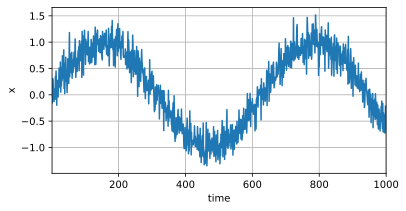

In [91]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 # 共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32) # 一个一维张量，包含从1到T的浮点数序列。它用于表示时间
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) # 一个一维张量，表示在时间序列上的一个函数。它通过对时间序列进行正弦函数的计算，并添加了一个服从正态分布的噪声
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。

In [92]:
tau = 4 # 时间延迟的长度
features = torch.zeros((T - tau, tau)) # 一个形状为(T - tau, tau)的张量，用于存储特征数据。其中，T是时间序列的长度
for i in range(tau):
    features[:, i] = x[i: T - tau + i] # x是一个形状为(T,)的张量，表示时间序列的输入数据
labels = x[tau:].reshape((-1, 1)) # 一个形状为(-1, 1)的张量，用于存储标签数据。其中，-1表示自动计算维度大小

batch_size, n_train = 16, 600 # batch_size：每个训练批次的样本数量，n_train：用于训练的样本数量
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True) # 一个用于训练的迭代器，通过d2l.load_array函数加载特征和标签数据，并按照batch_size进行分批次处理

在这里，我们使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [93]:
# 初始化网络权重函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight) # 用于初始化nn.Linear层的权重

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), # 创建了一个线性层，输入维度为4，输出维度为10。这个线性层将输入数据映射到一个10维的特征空间
                        nn.ReLU(), # 添加了一个ReLU激活函数层，用于引入非线性变换 
                        nn.Linear(10, 1)) # 创建了一个线性层，将10维的特征映射到一个单一的输出
    net.apply(init_weights) # 调用了一个自定义的函数init_weights，用于初始化网络的权重。这个函数会遍历网络的所有线性层，并使用Xavier均匀初始化方法对权重进行初始化
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备训练模型了。实现下面的训练代码的方式与前面几节中的循环训练基本相同

In [94]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr) # 创建了一个Adam优化器对象trainer，用于更新神经网络模型的参数。net.parameters()返回模型中所有需要更新的参数
    for epoch in range(epochs): # 用于控制训练的轮数
        for X, y in train_iter: # 用于遍历训练数据集
            trainer.zero_grad() # 调用trainer.zero_grad()将梯度清零
            l = loss(net(X), y) # 通过net(X)计算模型的输出，再将输出和真实标签y传入损失函数loss计算损失值l
            l.sum().backward() # 接着调用l.sum().backward()进行反向传播，计算参数的梯度
            trainer.step() # 最后，调用trainer.step()更新模型的参数
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}') # evaluate_loss(net, train_iter, loss)是一个辅助函数，用于计算整个训练集上的平均损失值

net = get_net()
train(net, train_iter, loss, 6, 0.01)

epoch 1, loss: 0.059520
epoch 2, loss: 0.053543
epoch 3, loss: 0.051069
epoch 4, loss: 0.050356
epoch 5, loss: 0.051617
epoch 6, loss: 0.049342


## 预测
由于训练损失很小，因此我们期望模型能有很好的工作效果。
让我们看看这在实践中意味着什么。
首先是检查模型预测下一个时间步的能力，
也就是*单步预测*（one-step-ahead prediction）。

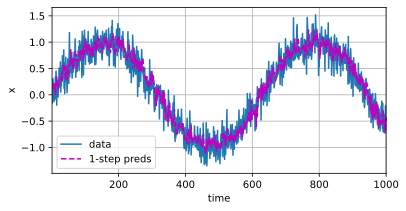

In [95]:
# 使用训练好的神经网络模型net对输入数据features进行预测，并将原始数据x和预测结果onestep_preds绘制成图表
onestep_preds = net(features)
d2l.plot([time, time[tau:]], # x轴的数据，包括原始数据的时间序列time和预测结果的时间序列time[tau:]
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', # y轴的数据，包括原始数据x和预测结果onestep_preds
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。
让我们看看效果如何。

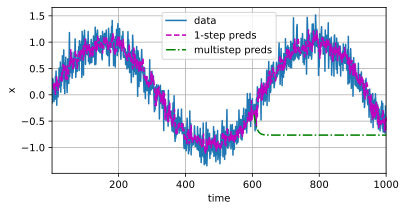

In [96]:
multistep_preds = torch.zeros(T) # 用于存储多步预测的结果。这个张量的形状是(T,)，其中T是时间步数
multistep_preds[: n_train + tau] = x[: n_train + tau] # 将x中的一部分数据赋值给multistep_preds来初始化多步预测的起始值。具体来说，它将x中从索引n_train + tau开始的部分赋值给multistep_preds中相应的位置
for i in range(n_train + tau, T): # 使用一个循环来生成剩余的多步预测。循环从索引n_train + tau开始，一直迭代到索引T-1。
    """ 
    使用神经网络net对multistep_preds[i - tau:i]进行预测，并将预测结果赋值给multistep_preds[i]。
    这里的multistep_preds[i - tau:i]是一个形状为(1, tau)的张量，它包含了multistep_preds中最近的tau个值。
    """
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1))) 

d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，
让我们更仔细地看一下$k$步预测的困难。

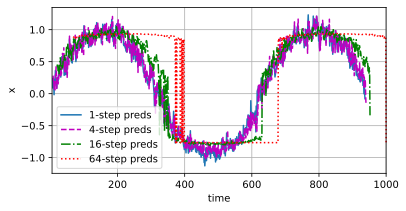

In [97]:
max_steps = 64 # 预测的最大步数
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps)) # 创建了一个全零的特征矩阵features，其形状为(T-tau-max_steps+1, tau+max_steps)，其中T是时间序列的长度，tau是时间延迟
""" 使用两个循环填充特征矩阵features的列 """
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau): # 从0到tau，用于填充features的前tau列。这些列是来自原始数据x的观测值，时间步从从i到i+T-tau-max_steps+1
    features[:, i] = x[i : i + T - tau - max_steps + 1] # 具体来说，对于每个i，我们将x[i : i+T-tau-max_steps+1]赋值给features[:, i]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps): # 从tau到tau+max_steps，用于填充features的后max_steps列。这些列是来自之前预测的值，其时间步从i到i+T-tau-max_steps+1
    """  
        具体来说，对于每个i，我们将net(features[:, i - tau : i]).reshape(-1)赋值给features[:, i]。
        这里，net是之前定义的神经网络模型，features[:, i - tau : i]是features中的一部分，用于输入到神经网络中进行预测。
    """
    features[:, i] = net(features[:, i - tau : i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。 虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的

## 小结

* 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
* 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
* 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
* 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。

In [ ]:
! pip install nbconvert
! jupyter nbconvert --to markdown sequence.ipynb